In [1]:
import wimprates as wr
import numericalunits as nu
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import dddm
from collections import defaultdict

import darkelf
from darkelf import targets

dddm.print_versions('dddm wimprates verne darkelf'.split())

Host DESKTOP-F4PI41P.
   module version                                          path                                     git
   python  3.10.4 /home/joran/miniconda3/envs/py3.10/bin/python                                    None
     dddm   3.0.2                /home/joran/software/dddm/dddm   branch:test_nb_and_drak_elf | dbdc530
wimprates   0.4.0      /home/joran/software/wimprates/wimprates branch:allow_different_shells | 5aab0bc
    verne   0.0.0              /home/joran/software/verne/verne                 branch:master | 5121604
  darkelf   0.0.0          /home/joran/software/darkelf/darkelf                   branch:main | 17e5670


,module,version,path,git
0,python,3.10.4,/home/joran/miniconda3/envs/py3.10/bin/python,None
1,dddm,3.0.2,/home/joran/software/dddm/dddm,branch:test_nb_and_drak_elf | dbdc530
2,wimprates,0.4.0,/home/joran/software/wimprates/wimprates,branch:allow_different_shells | 5aab0bc
3,verne,0.0.0,/home/joran/software/verne/verne,branch:master | 5121604
4,darkelf,0.0.0,/home/joran/software/darkelf/darkelf,branch:main | 17e5670


In [2]:
energies = np.linspace(0, 1_000, 11) # ev

In [3]:
MX = 10 #GeV/c2
SIGMA = 1e-38 #cm2
VESC=544
V0=220
RHO_0 = 0.3
TARGET='Ge'

In [4]:
shm = wr.StandardHaloModel(v_0=V0* nu.km/nu.s, 
                           v_esc=VESC* nu.km/nu.s,
                           rho_dm = RHO_0 * nu.GeV/nu.c0**2 / nu.cm**3 
                          )

In [5]:
dr = wr.rate_migdal(energies/1e3 * nu.keV, 
                    mw=MX * nu.GeV / nu.c0 ** 2, 
                    material=TARGET,
                    sigma_nucleon=SIGMA * nu.cm ** 2,
                    halo_model=shm,
                    include_approx_nr=0,
                   ) * (nu.keV * (1000 * nu.kg) * nu.year)


In [6]:
Ge_gpaw = darkelf.darkelf(target=TARGET, 
                          mX=MX*1e9, 
                          vesckms=VESC, 
                          mMed=float('inf'),
                          v0kms=V0,
                          filename=f"{TARGET}_gpaw_withLFE.dat")
Ge_gpaw.update_params(mediator='massive',)
Ge_gpaw.rhoX=RHO_0*1e9

 .... Loading files for Ge
Loaded Ge_gpaw_withLFE.dat for epsilon in electron regime
electronic ELF taken or calculated from J. Enkovaara et al.,Electronic structure calculations with GPAW: a real-space implementation of the projector augmented-wave method,Journal of Physics:Condensed Matter22(2010) 253202.
phonon ELF taken or calculated from M. Ikezawa and T. Nanba, Two-Phonon Difference Absorption Spectra in Ge Crystals, Journal of  the Physical Society of Japan 45 (1978) 148.
Loaded Ge_epsphonon_data2K.dat for epsilon in phonon regime
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000
Loaded Ge_atomic_Zion.dat for dark photon couplings
Loaded Ge_DoS.dat for density of states
Loaded Fn(omega) functions cor

In [7]:
dr_darkelf = Ge_gpaw.dRdomega_migdal(
    energies,
    sigma_n=SIGMA,
    method='ibe',     
    Nshell={'Si': 3, 'Ge': 6}[TARGET],
    approximation='free',
    Zionkdependence=False,
    Enth=0.1,
    fast=False,
)

dr_darkelf -= Ge_gpaw.dRdomega_migdal(
    energies,
    sigma_n=SIGMA,
    method='ibe',     
    Nshell={'Si': 1, 'Ge': 3}[TARGET],
    approximation='free',
    Zionkdependence=False,
    Enth=0.1,
    fast=False,
)
dr_darkelf *= (
    1e3 # kg -> ton
    * 1e3 # ev ->keV
)

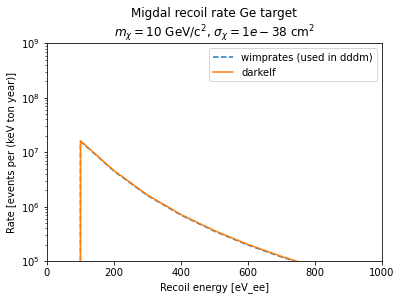

In [8]:
plt.plot(energies, dr, label='wimprates (used in dddm)', ls='--')
plt.plot(energies, dr_darkelf, label='darkelf')

plt.xlabel("Recoil energy [eV_ee]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title(f"Migdal recoil rate {TARGET} target\n$m_\chi = {MX}$ GeV/c${{}}^2$, $\sigma_\chi = {SIGMA}$ cm${{}}^2$")
plt.xlim(0, energies.max())

plt.yscale('log')
plt.ylim(1e5,1e9)
plt.legend()

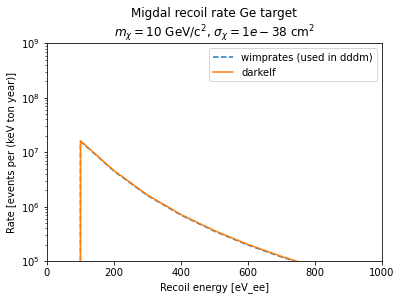

In [9]:
plt.plot(energies, dr, label='wimprates (used in dddm)', ls='--')
plt.plot(energies, dr_darkelf, label='darkelf')
# plt.plot(energies, dr_darkelf, label='darkelf/$\pi$')
# plt.plot(energies, dr_darkelf, label='darkelf/20')

plt.xlabel("Recoil energy [eV_ee]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title(f"Migdal recoil rate {TARGET} target\n$m_\chi = {MX}$ GeV/c${{}}^2$, $\sigma_\chi = {SIGMA}$ cm${{}}^2$")
plt.xlim(0, energies.max())

plt.yscale('log')
plt.ylim(1e5,1e9)
plt.legend()

### Match with wimprates
**NB!**: to get this match we had to manually disable form factors in wimprates as they are not taken into account in darkelf


10000.000 1.021
2782.559 1.021
774.264 1.021
215.443 1.021
59.948 1.021
16.681 1.023
4.642 1.028
1.292 1.045
0.359 1.144
0.100 1.322


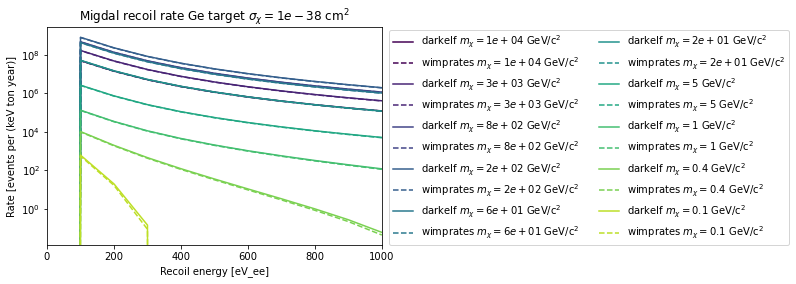

In [10]:
xs=np.logspace(-1, 4, 10)
df = defaultdict(list)
df['masses'] = xs

for i, MX in enumerate(xs[::-1]):
    Ge_gpaw.update_params(mX = MX*1e9)
    dr = wr.rate_migdal(energies/1e3 * nu.keV, 
                        mw=MX * nu.GeV / nu.c0 ** 2, 
                        material=TARGET,
                        sigma_nucleon=SIGMA * nu.cm ** 2,
                        halo_model=shm,
                        include_approx_nr=0,
                       ) * (nu.keV * (1000 * nu.kg) * nu.year)

    dr_darkelf = Ge_gpaw.dRdomega_migdal(
        energies,
        sigma_n=SIGMA,
        method='ibe',     
        Nshell={'Si': 3, 'Ge': 6}[TARGET],
        approximation='impulse',
        Zionkdependence=True,
        fast=False,
    )
    dr_darkelf *= (
        1e3 # kg -> ton
        * 1e3 # ev ->keV
    )
    fin = (np.isfinite(dr_darkelf)) & (np.isfinite(dr)) & (dr >0) & (dr_darkelf>0)
    div=np.mean(dr_darkelf[fin]/dr[fin])
    df['frac'] += [div]
    for attr in 'mX mN muxN muxnucleon muXe'.split():
        df[attr] += [getattr(Ge_gpaw, attr)]

    plt.plot(energies,
             dr_darkelf,
             c=plt.cm.viridis(i/len(xs)), 
             label=f'$\mathrm{{darkelf  }}$ $m_\chi = {MX:.1g}$ GeV/c${{}}^2$')
    plt.plot(energies, 
             dr, 
             c=plt.cm.viridis(i/len(xs)), 
             ls='--',  
             label=f'$\mathrm{{wimprates}}$ $m_\chi = {MX:.1g}$ GeV/c${{}}^2$')
    print(f'{MX:.3f} {div:.3f}')
plt.yscale('log')

plt.xlabel("Recoil energy [eV_ee]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title(f"Migdal recoil rate {TARGET} target $\sigma_\chi = {SIGMA}$ cm${{}}^2$")
plt.xlim(0, energies.max())

plt.yscale('log')
plt.legend(loc=(1.02,0), ncol=2)